# Cuaderno 30: Uso de heurísticas
## Heurística de inserción más cercana y heurística 3-OPT para el ATSP

$\newcommand{\card}[1]{\left| #1 \right|}$
$\newcommand{\tabulatedset}[1]{\left\{ #1 \right\}}$
$\newcommand{\ZZ}{\mathbb{Z}}$
$\newcommand{\RR}{\mathbb{R}}$

Dados: 
* un grafo dirigido **completo** $D=(V,A)$; y,
* un vector $c \in \ZZ^{A}$ de costos asociados a los arcos de $D$.

Consideraremos la formulación del *problema del agente viajero asimétrico (Asymmetric Traveling Salesman Problem, ATSP)* empleando desigualdades de corte: 

\begin{align*}
\min &\sum_{(i,j) \in A} c_{ij} x_{ij}\\ 
& \mbox{s.r.}\\
&\sum_{(i,j) \in \delta^{+}(i) } x_{ij} = 1, \quad \forall i \in V,\\
&\sum_{(j,i) \in \delta^{-}(i) } x_{ji} = 1, \quad \forall i \in V,\\
&\sum_{ij \in \delta^{+}(W)} x_{ij} \geq 1, \quad \forall W \subset V, \emptyset \neq W \neq V,\\
& x_{ij} \in \{0, 1\}, \quad \forall (i,j) \in A,
\end{align*}
donde $\delta^{+}(W) := \{ (i,j) \in A \, : \, i \in W, j \not\in W\}$.

En el Cuaderno 29 se implementó este modelo utilizando una función callback para separar dinámicamente las desigualdades de corte, tanto para soluciones enteras como para soluciones fraccionarias.

Una posibilidad para acelerar la solución de modelos de programación entera computacionalmente difíciles consiste en inicializar el solver con una solución factible de buena calidad, la cual puede encontrarse por métodos heurísticos. 

Una *heurística constructiva* es un algoritmo eficiente que produce una solución factible para un problema de optimización. La solución encontrada generalmente no es óptima, aunque se espera que su calidad sea "buena". Para el caso del ATSP, implementaremos en este cuaderno la **Heurística de la Mejor Inserción (Best-Insertion Heuristic)**, la misma que se describe a continuación:

1. Elegir $s, t \in V$ arbitrarios y construir el *tour parcial* $T=(s, t, s)$. Definir $W := V \setminus \{s, t\}$.
2. Mientras $W \neq \emptyset$, hacer:
  1. Para cada nodo $i \in W$ y para cada $k \in K:= \{1, \ldots, \card{T}-1 \}$, calcular $c_{ik}$ como el incremento en la longitud del tour $T$ al insertar el nodo $i$ entre las posiciones $k$ y $k+1$.
  2. Determinar $i^*$ y $k^*$ tales que $c_{i^*k^*} = \min_{i \in W} \min_{i \in K} \{ c_{ik}\}$.
  3. Insertar el nodo $i^*$ entre las posiciones $k^*$ y $k^* + 1$ del tour $T$.
  4. Actualizar $W:= W \setminus\{i^*\}$

Una *heurística de mejoramiento local* toma como entrada una solución factible y construye una nueva solución factible de mejor calidad realizando movimientos locales que mejoren el valor de la función objetivo. Por ejemplo, una heurística local para el ATSP es la heurística **3-OPT**:

Dado un tour factible $T$, seleccionar tres arcos $a_1$, $a_2$ y $a_3$ que no tengan nodos comunes entre sí, y eliminar estos arcos del tour. Al hacerlo, el tour $T$ se divide en tres caminos simples disjuntos $T_1$, $T_2$ y $T_3$. Suponer que el orden en el que estos caminos son visitados en $T$ es $(T_1, T_2, T_3)$, y observar que existen tres arcos disjuntos $b_1$, $b_2$ y $b_3$ que permiten recombinar los caminos en un nuevo tour $T^*$ donde estos son visitados en el orden $(T_1, T_3, T_2)$. Puede verse que la diferencia entre la longitud de los dos toures es $c(T^*) - c(T) = c(b_1) + c(b_2) + c(b_3) - c(a_1) - c(a_2) - c(a_3)$. El algoritmo consiste en realizar este tipo de sustituciones mientras sea posible mejorar el valor de la función objetivo. 

Vamos a utlizar las heurísticas de mejor inserción y 3-OPT para inyectar una solución inicial en nuestro modelo.

Definimos primero los datos. Usaremos la función `randint` del módulo random para generar valores aleatorios en el rango {0,..,100} para las coordenadas de cada nodo. Los costos de los arcos serán iguales a las distancias euclideanas entre sus nodos extremos. 

In [1]:
from gurobipy import *
import random as rm
import math 

# iniciar generador de numeros aleatorios
rm.seed(0)

# Numero de nodos del grafo
n = 200

# Nodos del grafo
V = tuplelist(range(1,n+1))

# Posiciones de los nodos en un plano euclideano entre (0,0) y (100, 100)
coordx={i : rm.randint(0,100) for i in V}
coordy={i : rm.randint(0,100) for i in V}

# los costos son las distancias eculideanas
c = tupledict({
    (i,j) : math.sqrt((coordx[i] - coordx[j])**2 + (coordy[i] - coordy[j])**2)
    for i in V for j in V if i!=j
})
A = c.keys()


Emplearemos el módulo `matplotlib` para graficar el tour de la solución. Definiremos para ello la función `dibujarTour` que recibe tres argumentos: una lista `coordx` con las coordenadas horizontales de los nodos, una lista `coordy` con las coordenadas verticales y un vector `tour` con una permutación de los nodos indicando el orden de visita en la solución.

In [2]:
import matplotlib.pyplot as plt
import random

def dibujarTour(coordx, coordy, tour):
    x = [coordx[i] for i in tour]
    y = [coordy[i] for i in tour]
    plt.figure(figsize=(15, 15))
    plt.plot(x, y, 'ro')
    Tx = [coordx[i] for i in tour]
    Ty = [coordy[i] for i in tour]
    Tx.append(coordx[tour[0]])
    Ty.append(coordy[tour[0]])
    plt.plot(Tx, Ty, 'b-')
    plt.show()

Para la generación dinámica de las desigualdades de corte, necesitaremos calcular el corte saliente de capacidad mínima en un grafo dirigido. Emplearemos para ello la siguiente función descrita en el Cuaderno 28:

In [3]:
import networkx as nx

# corte saliente de capacidad minima
def corte_sal_minimo(V, u):
    # Parametros:
    # V: lista con los nodos del grafo
    # u: diccionario indexado por los arcos del grafo, con sus capacidades
    # se fija un nodo s arbitrario
    s = V[0]
    V2 = [i for i in V if i!=s]
    G = nx.DiGraph()
    G.add_weighted_edges_from([(i, j, u[i,j]) for (i,j) in u.keys()], weight='u')
    # inicializar dmin con la suma de capacidades de todos los arcos
    dmin = sum([u[i,j] for (i, j) in u.keys()])
    hay_solucion = False
    # se calculan los cortes minimos (s, t) y (t, s) para todo t != s
    for t in V2: 
        d1, (W1, W1c) = nx.minimum_cut(G, s, t, capacity='u')
        d2, (W2, W2c) = nx.minimum_cut(G, t, s, capacity='u')
        if d1 < d2 and d1 < dmin:
            dmin, Wmin, Wminc = d1, W1, W1c
            hay_solucion = True
        elif d2 <= d1 and d2 < dmin:
            dmin, Wmin, Wminc = d2, W2, W2c
            hay_solucion = True
    if  not hay_solucion:
        print('*** Error:')
        print(V)
        for (i,j) in [(i, j) for (i, j) in u.keys() if i==1]:
            print([(1,j), u[1,j]])
    return dmin, Wmin, Wminc


Definimos ahora el objeto modelo, las variables y la función objetivo. 

Definimos las variables miembro `_x`, `_V` y `_A` dentro del objeto modelo para tener acceso a las variables de selección de arcos, la lista de nodos y la lista de arcos, respectivamente. 

In [4]:
# Crear el objeto modelo
m = Model('atsp-corte-lazy-heuristics')

# Crear las variables
x = m.addVars(A, name="x", vtype=GRB.BINARY)

# Crear la funcion objetivo
m.setObjective(x.prod(c,'*'), GRB.MINIMIZE)

# Crear variables en el objeto modelo para tener acceso a x, V y A
m._x = x
m._V = V
m._A = A


--------------------------------------------
--------------------------------------------

Using license file /Users/ltorres/gurobi.lic
Academic license - for non-commercial use only


Añadimos las restricciones de grado. 

In [5]:
# Restricciones de grado saliente
m.addConstrs((x.sum(i,'*') == 1 for i in V), "g_saliente");

# Restricciones de grado entrante
m.addConstrs((x.sum('*', i) == 1 for i in V), "g_entrante");



Definimos una función callback para separar dinámicamente las restricciones de corte. Esta función actúa cada vez que el solver encuentra una nueva solución entera que satisface las restricciones de grado (`where == GRB.Callback.MIPSOL`), o cuando termina el procesamiento de un nodo del árbol de branch-and-bound y se dispone de una solución fraccionaria a la relajación lineal problema (`where == GRB.Callback.MIPNODE`). 

Cuando se dispone de una solución entera, la función accede a los valores de las variables a través del llamado a `cbGetSolution`. A partir de estos valores, la función implementa un algoritmo de marcaje para determinar el conjunto W de todos los nodos que pueden ser alcanzados desde el nodo 1. Si este conjunto es distinto de V, el mismo está asociado a una desigualdad de corte violada por `x`.

Cuando la función callback es llamada luego del procesamiento de un nodo del árbol de branch-and-bound (`where == GRB.Callback.MIPNODE`), es necesario en primer lugar verificar que se dispone de una solución fraccionaria, llamando a la función `cbGet(GRB.Callback.MIPNODE_STATUS)` y comparando su valor de retorno con `GRB.OPTIMAL`. En este caso, los valores de la solución fraccionaria son recuperados llamando a la función `cbGetNodeRel`. Estos valores se usan como capacidades en los arcos del grafo del problema. Se emplean las funciones descritas en el Cuaderno 30 para calcular un corte de capacidad mínimima en el grafo. Si la capacidad de este corte es inferior a 1, se separa la desigualdad correspondiente.

In [6]:
# Funcion callback para separar desigualdades de corte
def mycallback(model, where):
    # Esta funcion se activara cuando se encuentre una nueva solucion entera
    if where == GRB.Callback.MIPSOL:
        # Recuperar los valores de la solucion actual
        vx = model.cbGetSolution(model._x)
        # Determinar los arcos seleccionados en la solucion
        L = [(i,j) for (i,j) in model._A if vx[i,j]>0.9]
        # Construir la lista W de nodos que pueden ser alcanzados desde 1
        W = [1]
        i = 1
        while True :
            N = [k for k in model._V if (i,k) in L]
            if len(N)>1:
                print("Error en desigualdad de grado:")
                for k in N:
                    print("{}-->{}: {}".format(i,k, vx[i,k]))
            j = N.pop()
            a = (i,j) 
            L.remove(a)
            if j==1: break
            W.append(j)
            i = j
        # Si W!=V, agregar la desigualdad de corte asociada a W
        if len(W)!=len(model._V):
            Wc = [i for i in model._V if i not in W]
            model.cbLazy(model._x.sum(W, Wc) >= 1)
    # Esta funcion se activara cuando se encuentre la solucion optima en un nodo
    elif where == GRB.Callback.MIPNODE:
        if model.cbGet(GRB.Callback.MIPNODE_STATUS) == GRB.OPTIMAL:
            # Recuperar los valores de la solucion (fraccionaria) actual
            vx = model.cbGetNodeRel(model._x)
            # Crear diccionario de capacidades (=valores de x) indexado por los arcos
            D={(i,j) : vx[i,j] for (i,j) in model._A}
            # encontrar el corte saliente de capacidad minima
            u, W, Wc = corte_sal_minimo(model._V, D)
            # Si la capacidad de este corte es inferior a 1, agregar nueva desigualdad lazy
            if u <= 0.99:
                model.cbLazy(model._x.sum(W, Wc) >= 1)


Para poder utilizar restricciones tipo *lazy* en un modelo, debe fijarse el parámetro `LazyConstraints` al valor de 1.

In [7]:
# Configurar Gurobi para usar restricciones lazy
m.Params.LazyConstraints = 1


Changed value of parameter LazyConstraints to 1
   Prev: 0  Min: 0  Max: 1  Default: 0


Fijamos un límite para el tiempo de cálculo y una tolerancia para la brecha de optimalidad:

In [8]:
# Terminar al alcanzar un Gap del 10%
m.Params.MIPGap = 0.1

# Terminar luego de 240 segundos
m.Params.TimeLimit = 240

Changed value of parameter MIPGap to 0.1
   Prev: 0.0001  Min: 0.0  Max: inf  Default: 0.0001
Changed value of parameter TimeLimit to 240.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf


Construimos un tour $T$ empleando la heurística de mejor inserción (*Best-Insertion Heuristic*): 

In [9]:
# Heurística de mejor insercion (best-insertion)
# construir una lista T con el orden de visita de los nodos en el tour
# Tour inicial:
T = [1, 2, 1]
# Nodos por procesar:
W = [i for i in V if not i in [1,2]]
# Constante suficientemente alta
# Repetir mientras W contenga nodos
while W!=[]:
    # construir una lista L con tuplas (c_i, j_i, i) donde:
    # c_i : mejor costo de insercion de i en el tour T
    # j_i : mejor posicion de insercion de i en el tour T, 1 <= j_i <= |T|-1
    L = []
    for i in W:
        # construimos primero una lista L_i con tuplas (c_ik, k)
        # c_ik: costo de insertar i en la posicion k
        Li = [(c[T[k-1],i] + c[i, T[k]] - c[T[k-1], T[k]], k) for k in range(1, len(T)-1)]
        # agregamos el elemento de Li de costo minimo a L
        # recordar que para ordenar tuplas se emplear por defecto el criterio lexicográfico
        ci, ji = min(Li)
        L.append((ci, ji, i))
    # determinar el elemento de insercion mas barata, y su posicion
    (delta, j, i) = min(L)
    # insertar i en T en la posicion j
    T.insert(j, i)
    # eliminar i de W
    W.remove(i)

print(T)
print(sum([c[T[i],T[i+1]] for i in range(0, len(T)-1)]))
       

[1, 177, 119, 138, 60, 10, 106, 98, 162, 125, 83, 140, 176, 178, 109, 57, 147, 157, 199, 30, 112, 26, 173, 130, 149, 12, 75, 63, 38, 85, 179, 156, 107, 132, 7, 34, 6, 15, 89, 90, 127, 88, 174, 167, 165, 161, 39, 143, 133, 120, 186, 54, 82, 21, 139, 175, 166, 33, 153, 3, 77, 123, 45, 71, 67, 58, 110, 24, 51, 29, 148, 64, 62, 31, 172, 48, 42, 80, 97, 194, 121, 164, 196, 134, 126, 40, 55, 19, 159, 9, 116, 168, 135, 105, 192, 56, 94, 13, 104, 129, 182, 84, 117, 23, 86, 76, 188, 11, 43, 44, 92, 136, 36, 32, 198, 61, 169, 114, 191, 115, 108, 158, 113, 102, 14, 184, 87, 78, 93, 197, 47, 4, 183, 137, 163, 181, 50, 16, 154, 152, 200, 69, 122, 17, 99, 5, 124, 66, 145, 101, 185, 189, 68, 146, 46, 41, 70, 171, 160, 150, 20, 35, 74, 73, 28, 180, 170, 193, 49, 103, 65, 187, 18, 100, 22, 79, 27, 155, 144, 81, 91, 96, 8, 128, 52, 72, 195, 37, 95, 131, 141, 59, 142, 25, 118, 111, 53, 151, 190, 2, 1]
1345.572427632879


Mejoramos localmente el tour $T$ usando una heurística 3-OPT:

In [10]:
# Mejorar T usando 3-OPT
# este lazo se repite mientras se encuentren mejoras
hay_mejoras = True
while hay_mejoras:
    hay_mejoras = False
    for k1 in range(1, len(T)-5):
        for k2 in range(k1+2, len(T)-3):
            for k3 in range(k2+2, len(T)-1):
                # determinar variacion del costo al ejecutar el intercambio:
                delta = c[T[k1], T[k2+1]] + c[T[k2], T[k3+1]] + c[T[k3], T[k1+1]] \
                      - c[T[k1], T[k1+1]] - c[T[k2], T[k2+1]] - c[T[k3], T[k3+1]]
                # si la variacion es negativa, realizar el intercambio
                if delta < -0.01:
                    T = T[0:k1+1] + T[k2+1:k3+1] + T[k1+1:k2+1] + T[k3+1:len(T)]
                    hay_mejoras = True
            
print (T)
print(sum([c[T[i],T[i+1]] for i in range(0, len(T)-1)]))


[1, 177, 119, 138, 60, 10, 106, 98, 162, 125, 83, 140, 176, 178, 109, 57, 147, 157, 199, 30, 112, 26, 173, 130, 149, 12, 75, 63, 38, 85, 179, 156, 153, 3, 33, 166, 77, 123, 45, 71, 67, 48, 42, 80, 97, 194, 121, 164, 40, 55, 116, 168, 135, 105, 192, 56, 94, 13, 104, 129, 182, 84, 117, 11, 43, 44, 92, 136, 36, 32, 198, 61, 101, 20, 169, 114, 191, 115, 108, 158, 113, 102, 14, 184, 87, 78, 93, 197, 47, 4, 183, 137, 163, 181, 50, 16, 154, 152, 200, 69, 122, 17, 99, 5, 124, 66, 145, 185, 189, 68, 146, 46, 41, 70, 28, 180, 171, 160, 150, 35, 74, 73, 170, 193, 49, 103, 65, 187, 18, 100, 22, 79, 27, 155, 144, 81, 91, 96, 8, 128, 52, 72, 195, 37, 95, 131, 141, 59, 76, 188, 23, 86, 142, 25, 118, 111, 53, 151, 190, 2, 19, 159, 9, 126, 196, 134, 31, 172, 58, 175, 89, 90, 127, 88, 174, 167, 165, 161, 39, 143, 133, 120, 186, 54, 82, 51, 29, 24, 148, 110, 64, 62, 21, 139, 34, 6, 15, 107, 132, 7, 1]
1269.567907069825


Insertamos el tour $T$ como una solución inicial en el modelo. Para ello, fijamos el atributo `Start` de cada variable al valor correspondiente en la solución asociada a $T$. 

Al terminar de fijar los valores iniciales para cada variable, es necesario llamar al método `update` del objeto modelo.

In [13]:
# originalmente, fijamos el valor de inicio de todas las variables a cero:
for i,j in A:
    x[i,j].setAttr('Start', 0.0)

# luego  fijar a 1 las variables asociadas a los arcos del tour T
for k in range(1, len(T)):
    x[T[k-1], T[k]].setAttr('Start', 1.0)

# es necesario llamar a update() luego de cambiar los atributos de variables, de restricciones o del modelo
m.update()
    

Finalmente, resolvemos el modelo y mostramos la solución, en caso de que se haya encontrado una solución factible (si `m.status` es `GRB.Status.OPTIMAL` o `GRB.Status.SUBOPTIMAL`).

In [14]:

# Calcular la solucion optima
m.optimize(mycallback)

# Escribir la solucion
if ((m.status == GRB.Status.OPTIMAL) or 
   (m.status == GRB.Status.SUBOPTIMAL)):
    # Recuperar los valores de las variables
    vx = m.getAttr('x', x)
    print('\nTour optimo:')
    for i,j in A:
        if vx[i,j] > 0:
            print('{} --> {}'.format(i, j))


Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (mac64)
Optimize a model with 400 rows, 39800 columns and 79600 nonzeros
Model fingerprint: 0xbb5efe64
Variable types: 0 continuous, 39800 integer (39800 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]

User MIP start did not produce a new incumbent solution
User MIP start violates constraint g_saliente[1] by 1.000000000
Loaded MIP start from previous solve with objective 1269.57

Presolve time: 0.21s
Presolved: 400 rows, 39800 columns, 79600 nonzeros
Variable types: 0 continuous, 39800 integer (39800 binary)

Root relaxation: objective 8.745625e+02, 334 iterations, 0.02 seconds
Another try with MIP start

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  879.34772    0    8 1269.56791  879.34772  30.7%     -

Si encontramos alguna solución factible, el siguiente fragmento de código nos permite graficarla.

[(1, 194), (2, 105), (3, 157), (4, 86), (5, 14), (6, 58), (7, 161), (8, 177), (9, 15), (10, 121), (11, 150), (12, 131), (13, 80), (14, 47), (15, 127), (16, 28), (17, 182), (18, 85), (19, 92), (20, 1), (21, 67), (22, 84), (23, 17), (24, 102), (25, 88), (26, 114), (27, 87), (28, 90), (29, 122), (30, 126), (31, 183), (32, 46), (33, 152), (34, 61), (35, 8), (36, 73), (37, 91), (38, 13), (39, 104), (40, 195), (41, 151), (42, 3), (43, 78), (44, 107), (45, 97), (46, 191), (47, 165), (48, 41), (49, 55), (50, 82), (51, 200), (52, 56), (53, 65), (54, 4), (55, 155), (56, 77), (57, 21), (58, 45), (59, 113), (60, 30), (61, 42), (62, 179), (63, 167), (64, 172), (65, 169), (66, 147), (67, 156), (68, 53), (69, 11), (70, 119), (71, 18), (72, 171), (73, 139), (74, 51), (75, 196), (76, 110), (77, 190), (78, 175), (79, 69), (80, 141), (81, 98), (82, 33), (83, 81), (84, 54), (85, 137), (86, 136), (87, 94), (88, 23), (89, 95), (90, 160), (91, 60), (92, 199), (93, 170), (94, 134), (95, 112), (96, 123), (97, 

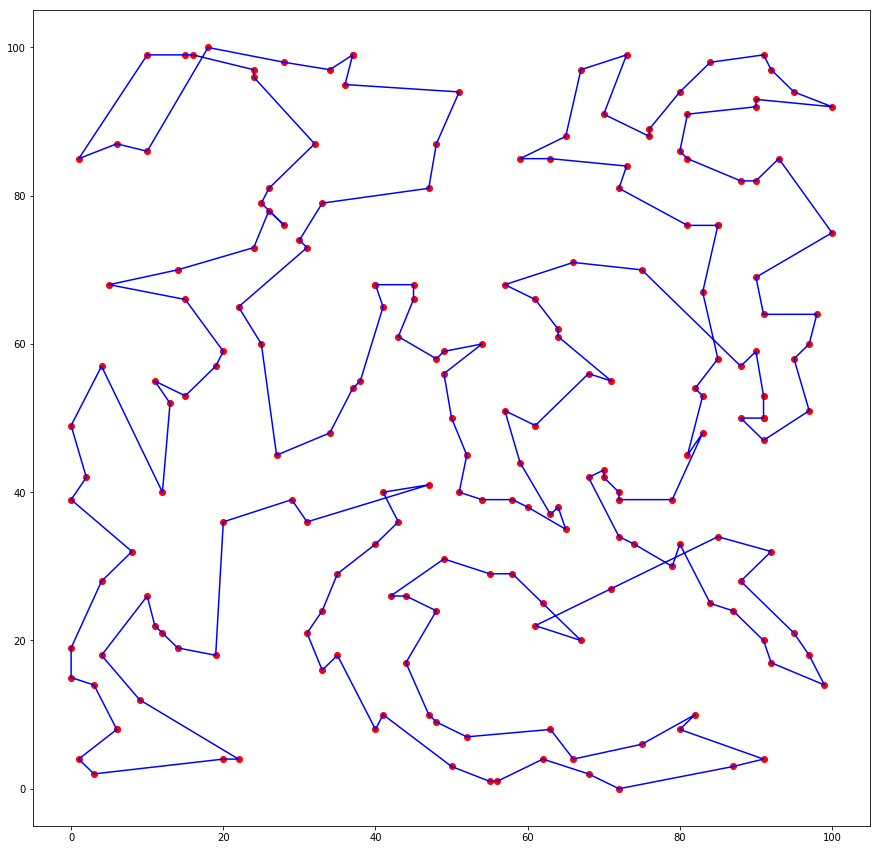

In [98]:
# Crear lista con arcos seleccionados en la solucion
vx = m.getAttr('x', x)
L = [(i,j) for i,j in A if vx[i,j]>0.9]
print L

# Recuperar el tour como un ordenamiento de los nodos
T = [1]
# nodo actual:
i = 1
while True:
    # Determinar sucesor de i
    N = [j for j in V if (i,j) in L]
    j = N.pop()
    a = (i,j) 
    L.remove(a)
    # Colocar sucesor en la lista del tour y actualizar i
    T.append(j)
    i = j
    # Terminar cuando el nodo colocado sea 1
    if i==1: break;
        
# Graficar el tour
dibujarTour(coordx, coordy, T)    

## Código completo

Se reproduce a continuación el código completo del modelo anterior.

In [5]:
# Implementación de modelos lineales enteros
# Problema del agente viajero asimétrico (ATSP)
# Implementación con desigualdades lazy y heurísticas para una solución inicial

# Luis M. Torres (EPN 2020)

from gurobipy import *
import random as rm
import math 
import networkx as nx

def dibujarTour(coordx, coordy, tour):
    x = [coordx[i] for i in tour]
    y = [coordy[i] for i in tour]
    plt.figure(figsize=(15, 15))
    plt.plot(x, y, 'ro')
    Tx = [coordx[i] for i in tour]
    Ty = [coordy[i] for i in tour]
    Tx.append(coordx[tour[0]])
    Ty.append(coordy[tour[0]])
    plt.plot(Tx, Ty, 'b-')
    plt.show()

# Funciona para calcular un corte saliente de capacidad minima
def corte_sal_minimo(V, u):
    # Parametros:
    # V: lista con los nodos del grafo
    # u: diccionario indexado por los arcos del grafo, con sus capacidades
    # se fija un nodo s arbitrario
    s = V[0]
    V2 = [i for i in V if i!=s]
    G = nx.DiGraph()
    G.add_weighted_edges_from([(i, j, u[i,j]) for (i,j) in u.keys()], weight='u')
    # inicializar dmin con la suma de capacidades de todos los arcos
    dmin = sum([u[i,j] for (i, j) in u.keys()])
    hay_solucion = False
    # se calculan los cortes minimos (s, t) y (t, s) para todo t != s
    for t in V2: 
        d1, (W1, W1c) = nx.minimum_cut(G, s, t, capacity='u')
        d2, (W2, W2c) = nx.minimum_cut(G, t, s, capacity='u')
        if d1 < d2 and d1 < dmin:
            dmin, Wmin, Wminc = d1, W1, W1c
            hay_solucion = True
        elif d2 <= d1 and d2 < dmin:
            dmin, Wmin, Wminc = d2, W2, W2c
            hay_solucion = True
    if  not hay_solucion:
        print('*** Error:')
        print(V)
        for (i,j) in [(i, j) for (i, j) in u.keys() if i==1]:
            print([(1,j), u[1,j]])
    return dmin, Wmin, Wminc

# Funcion callback para separar desigualdades de corte
def mycallback(model, where):
    # Esta funcion se activara cuando se encuentre una nueva solucion entera
    if where == GRB.Callback.MIPSOL:
        # Recuperar los valores de la solucion actual
        vx = model.cbGetSolution(model._x)
        # Determinar los arcos seleccionados en la solucion
        L = [(i,j) for (i,j) in model._A if vx[i,j]>0.9]
        # Construir la lista W de nodos que pueden ser alcanzados desde 1
        W = [1]
        i = 1
        while True :
            N = [k for k in model._V if (i,k) in L]
            if len(N)>1:
                print("Error en desigualdad de grado:")
                for k in N:
                    print("{}-->{}: {}".format(i,k, vx[i,k]))
            j = N.pop()
            a = (i,j) 
            L.remove(a)
            if j==1: break
            W.append(j)
            i = j
        # Si W!=V, agregar la desigualdad de corte asociada a W
        if len(W)!=len(model._V):
            Wc = [i for i in model._V if i not in W]
            model.cbLazy(model._x.sum(W, Wc) >= 1)
    # Esta funcion se activara cuando se encuentre la solucion optima en un nodo
    elif where == GRB.Callback.MIPNODE:
        if model.cbGet(GRB.Callback.MIPNODE_STATUS) == GRB.OPTIMAL:
            # Recuperar los valores de la solucion (fraccionaria) actual
            vx = model.cbGetNodeRel(model._x)
            # Crear diccionario de capacidades (=valores de x) indexado por los arcos
            D={(i,j) : vx[i,j] for (i,j) in model._A}
            # encontrar el corte saliente de capacidad minima
            u, W, Wc = corte_sal_minimo(model._V, D)
            # Si la capacidad de este corte es inferior a 1, agregar nueva desigualdad lazy
            if u <= 0.99:
                model.cbLazy(model._x.sum(W, Wc) >= 1)
    
# iniciar generador de numeros aleatorios
rm.seed(0)

# Numero de nodos del grafo
n = 100

# Nodos del grafo
V = tuplelist(range(1,n+1))

# Posiciones de los nodos en un plano euclideano entre (0,0) y (100, 100)
coordx={i : rm.randint(0,100) for i in V}
coordy={i : rm.randint(0,100) for i in V}

# los costos son las distancias eculideanas
c = tupledict({
    (i,j) : math.sqrt((coordx[i] - coordx[j])**2 + (coordy[i] - coordy[j])**2)
    for i in V for j in V if i!=j
})
A = c.keys()


try:
    # Crear el objeto modelo
    m = Model('atsp-corte-lazy')

    # Crear las variables
    x = m.addVars(A, name="x", vtype=GRB.BINARY)

    # Crear la funcion objetivo
    m.setObjective(x.prod(c,'*'), GRB.MINIMIZE)

    # Crear variables en el objeto modelo para tener acceso a x, V y A
    m._x = x
    m._V = V
    m._A = A

    # Restricciones de grado saliente
    m.addConstrs((x.sum(i,'*') == 1 for i in V), "g_saliente");

    # Restricciones de grado entrante
    m.addConstrs((x.sum('*', i) == 1 for i in V), "g_entrante");

    # Escribir el modelo a un archivo
    # m.write('atsp-corte-lazy.lp')

    # Configurar Gurobi para usar restricciones lazy
    m.Params.LazyConstraints = 1

    # Terminar al alcanzar un Gap del 10%
    m.Params.MIPGap = 0.1

    # Terminar luego de 240 segundos
    m.Params.TimeLimit = 240

    # Heuristica de mejor insercion (best-insertion)
    # construir una lista T con el orden de visita de los nodos en el tour
    # Tour inicial:
    T = [1, 2, 1]
    # Nodos por procesar:
    W = [i for i in V if not i in [1,2]]
    # Constante suficientemente alta
    # Repetir mientras W contenga nodos
    while W!=[]:
        # construir una lista L con tuplas (c_i, j_i, i) donde:
        # c_i : mejor costo de insercion de i en el tour T
        # j_i : mejor posicion de insercion de i en el tour T, 1 <= j_i <= |T|-1
        L = []
        for i in W:
            # construimos primero una lista L_i con tuplas (c_ik, k)
            # c_ik: costo de insertar i en la posicion k
            Li = [(c[T[k-1],i] + c[i, T[k]] - c[T[k-1], T[k]], k) for k in range(1, len(T)-1)]
            # agregamos el elemento de Li de costo minimo a L
            ci, ji = min(Li)
            L.append((ci, ji, i))
        # determinar el elemento de insercion mas barata, y su posicion
        (delta, j, i) = min(L)
        # insertar i en T en la posicion j
        T.insert(j, i)
        # eliminar i de W
        W.remove(i)

    print(T)
    print(sum([c[T[i],T[i+1]] for i in range(0, len(T)-1)]))

    # Heuristica de mejoramiento local 3-OPT
    # este lazo se repite mientras se encuentren mejoras
    hay_mejoras = True
    while hay_mejoras:
        hay_mejoras = False
        for k1 in range(1, len(T)-5):
            for k2 in range(k1+2, len(T)-3):
                for k3 in range(k2+2, len(T)-1):
                    # determinar variacion del costo al ejecutar el intercambio:
                    delta = c[T[k1], T[k2+1]] + c[T[k2], T[k3+1]] + c[T[k3], T[k1+1]] \
                          - c[T[k1], T[k1+1]] - c[T[k2], T[k2+1]] - c[T[k3], T[k3+1]]
                    # si la variacion es negativa, realizar el intercambio
                    if delta < -0.01:
                        T = T[0:k1+1] + T[k2+1:k3+1] + T[k1+1:k2+1] + T[k3+1:len(T)]
                        hay_mejoras = True
            
    print (T)
    print(sum([c[T[i],T[i+1]] for i in range(0, len(T)-1)]))
    
    # inyectar solucion inicial en el solver
    # originalmente, fijamos el valor de inicio de todas las variables a cero:
    for i,j in A:
        x[i,j].setAttr('Start', 0.0)

    # luego  fijar a 1 las variables asociadas a los arcos del tour T
    for k in range(1, len(T)):
        x[T[k-1], T[k]].setAttr('Start', 1.0)

    # es necesario llamar a update() luego de cambiar los atributos de variables, de restricciones o del modelo
    m.update()

    # Calcular la solucion optima
    m.optimize(mycallback)

    # Escribir la solucion
    if m.getAttr(GRB.Attr.SolCount) > 0:
        # Recuperar los valores de las variables
        vx = m.getAttr('x', x)
        print('\nTour optimo:')
        for i,j in A:
            if vx[i,j] > 0:
                print('{} --> {}'.format(i, j))

        # Recuperar el tour como un ordenamiento de los nodos
        L = [(i,j) for i,j in A if vx[i,j]>0.9]
        T = [1]
        i = 1
        while True:
            # Determinar sucesor de i
            N = [j for j in V if (i,j) in L]
            j = N.pop()
            a = (i,j) 
            L.remove(a)
            # Colocar sucesor en la lista del tour y actualizar i
            T.append(j)
            i = j
            # Terminar cuando el nodo colocado sea 1
            if i==1: break;
        # Graficar el tour
        dibujarTour(coordx, coordy, T)        
        
except GurobiError as e:
    print('Se produjo un error de Gurobi: codigo: ' + str(e.errno) + ": " + str(e))

except AttributeError:
    print('Se produjo un error de atributo')


--------------------------------------------
--------------------------------------------

Using license file /Users/ltorres/gurobi.lic
Academic license - for non-commercial use only
Changed value of parameter LazyConstraints to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Changed value of parameter MIPGap to 0.1
   Prev: 0.0001  Min: 0.0  Max: inf  Default: 0.0001
Changed value of parameter TimeLimit to 240.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
[1, 12, 60, 85, 52, 46, 100, 98, 22, 38, 79, 36, 28, 41, 66, 17, 27, 5, 26, 18, 74, 4, 65, 35, 20, 16, 68, 61, 10, 96, 75, 32, 95, 44, 77, 6, 45, 84, 89, 76, 37, 8, 63, 99, 91, 69, 87, 30, 49, 73, 50, 78, 57, 47, 93, 83, 70, 14, 81, 3, 15, 71, 80, 97, 58, 40, 13, 25, 55, 53, 56, 88, 7, 23, 42, 67, 43, 72, 92, 33, 11, 59, 86, 48, 90, 34, 39, 94, 21, 64, 82, 51, 29, 31, 19, 24, 62, 9, 54, 2, 1]
935.0137877278158
[1, 12, 63, 81, 99, 91, 14, 69, 87, 50, 78, 57, 47, 93, 83, 70, 30, 49, 73, 100, 98, 46, 22, 38, 79, 28, 41, 66, 74, 4, 65, 35, 

NameError: name 'plt' is not defined